# Вступление

## Тема - Рекомендация тарифов

**Описание**
Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра». В нашем случае это 1 или 0.

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — сделали ее в предыдущем проекте.

**Цель:** Найти и построить модель с максимально большим значением accuracy.

**План действий:**

1. Открыть и изучить файл с данными.
2. Разделить исходные данные на обучающую, валидационную и тестовую выборки.
3. Исследовать качество разных моделей, меняя гиперпараметры.
4. Проверить качество модели на тестовой выборке.
5. Дополнительное задание: проверить модель на вменяемость.

# Подготовка

In [58]:
# Добавляем все необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [59]:
# открываем и чекаем исходный датасет
try:
    data = pd.read_csv('users_behavior.csv')
except FileNotFoundError:
    data = pd.read_csv('/datasets/users_behavior.csv')

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [61]:
data.duplicated().sum()

0

Видим, что данные без явных пропусков. Дубликатов нет. Проверим на выбросы.
P.S. я сначала построил 3 модели, поигрался с гиперпараметрами, получил плохие результаты (все не превышали 0.71 Accuracy), начал читать как еще улучшить модель, и только тогда допер что надо выбросы проверить. Поэтому сделаем вид, что я сразу эту учел и с самого начала начал изучать выбросы =)

In [62]:
data.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Видим, что аномальных значений по нижней границу нет. Везде минимальное значение - 0. А вот с максимальным значением стоит разобраться и проверить на наличие выбросов. Кроме колонки is_ultra. Там у нас по умолчанию должны быть только значени 0 и 1. Таблица describe это подтверждает, что мин значение - 0 а мах значение - 1. Значит тут точно нет аномальных значений.

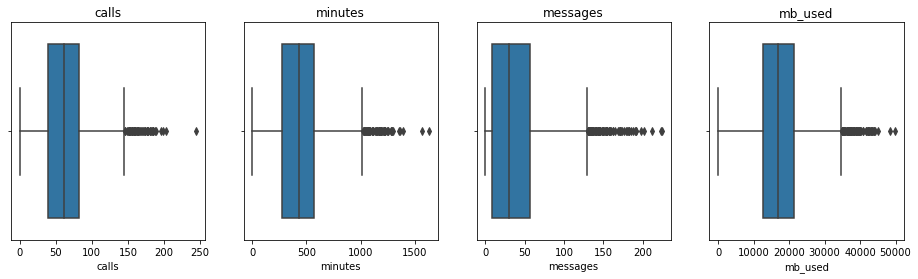

In [63]:
# СТроим боксплоты чтобы увидеть картину по выбросам для каждой колонки

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
i = 0
for column in data.drop('is_ultra', axis=1).columns:
    sns.boxplot(x=data[column], ax=axs[i])
    axs[i].set_title(column)
    i += 1

plt.show()

In [64]:
# Видим, что выбросы есть по каждому значению и при том довольно много их. Для построения более качественной модели есть смысл избавиться от выбросов, хотя бы оставив только те что в ходят в деапозон Q1 - IQR и Q3 + IQR. Но так как все значения у нас обладают минимальным значением в 0, то нижню границу 0 и можно оставить.



# Рассчитаем IQR для каждого значения, границу Q3 + IQR и отфильтруем датасет

# for column in data.drop('is_ultra', axis=1).columns:
#     IQR = data[column].quantile(0.75) - data[column].quantile(0.25)
#     up = data[column].quantile(0.75) + 1.5 * IQR
#     data = data[(data[column] <= up)]

# data.info()

# Итого мы получили датасет примерно на 250 значений меньше. Ну, думаю можно с этим жить, зато точно будем знать, что наша модель описывается более качественно.

In [65]:
data['is_ultra'].value_counts() / data.shape[0]

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

Здесь видим, что тарифов ультра (1) у нас 30% от всего датасета, а тарифов смарт (0) - 70%.

# Разделяем исходные данные на обучающую, валидационную и тестовую выборки.

In [66]:
# Разделим выборку на валидационную и тестовую.
data_train, data_test = train_test_split(data, test_size=0.2, random_state=12345, stratify=data['is_ultra'])
data_train, data_valid = train_test_split(data_train, test_size=0.25, random_state=12345, stratify=data_train['is_ultra'])

#  Определим зависимую и независимые переменные для выделенных датасетов
X_train = data_train.drop(['is_ultra'], axis=1)
Y_train = data_train['is_ultra']
X_test = data_test.drop(['is_ultra'], axis=1)
Y_test = data_test['is_ultra']
X_valid = data_valid.drop(['is_ultra'], axis=1)
Y_valid = data_valid['is_ultra']

# Нормализуем значения
# norm = Normalizer().fit(X_train)
# X_train = norm.transform(X_train)
# X_test = norm.transform(X_test)
# X_valid = norm.transform(X_valid)


# Создадим словарь на будущее: модель - качество
sl = {}


# Построение изученных моделей для классификации. Исследуем их качество. Поиграемся с гиперпараметрами. Проверим качество модели на тестовой выборке.

## Решающее дерево

Сразу начнем перебор по 3 гиперпарамтерам по глубине, узлам и листьям. Обучать модель будем на обучающей выборке. Проверять качество модели на валидационной выборке. Отобрав идеальные гиперпараметры по качеству валидационной выборке - построим заново модель по обучающей выборке и проверим ее на тестовой. Сохраним значение качества в словарик.

In [67]:
# Перебираем гиперпараметры и выбираем модель с максимальным значением Accuracy, запоминая гипперпараметры такой модели

best_res = 0
good_tree = None
for depth in range(1,10):
    for split in range(2,10):
        for leaf in range(1,10):
            model = DecisionTreeClassifier(max_depth=depth, 
                                           min_samples_split=split, 
                                           min_samples_leaf=leaf, 
                                           criterion='gini',
                                           random_state=12345)
            model.fit(X_train, Y_train)
            pred_valid = model.predict(X_valid)
            res = accuracy_score(Y_valid, pred_valid)
            if res > best_res:
                best_valid = pred_valid
                best_res = res
                best_params = {'max_depth': depth, 'min_samples_split': split, 'min_samples_leaf': leaf}
                good_tree = model

print(best_res)                
print(best_params)
sl['Decision Tree'] = [best_res, best_params, good_tree]

0.8164852255054432
{'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1}


Получилось, что наилучший результат в 0.8164852255054432 - достигается при глубине дерева =5, минимальной количестве узлов = 2 и минимальном количестве листьев = 1.

In [68]:
# pred_test = good_tree.predict(X_test)
# test_accuracy = accuracy_score(Y_test, pred_test)
# print("Accuracy на тестовой выборке:", test_accuracy)

# sl['Decision Tree'] = [test_accuracy, best_params]

Используем метрику f1_score, с учетом дисбаланса классов - average='weighted'

In [69]:
f1 = f1_score(Y_valid, best_valid, average='weighted')

print(f1)

0.8043433389476315


В целом результат больше 0.5, даже ближе к 1, это предпосылка для того, что можно считать модель достаточно хорошей

## Случайный лес

Используя алгоритм случайного леса, в качестве гиперпараметров так же будем перебирать глубину, узлы и листья, а так же количество деревьев в лесу кратное 10.

In [70]:
best_res = 0
good_forest = None
for est in range(10,101,10):
    for depth in range(1, 5):
        for split in range(2,5):
            for leaf in range(1,5):
                model = RandomForestClassifier(n_estimators=est,
                                               min_samples_split=split,
                                               max_depth=depth,
                                               min_samples_leaf=leaf,
                                               random_state=12345)
                model.fit(X_train, Y_train)
                pred_valid = model.predict(X_valid)
                res = accuracy_score(Y_valid, pred_valid)
                if res > best_res:
                    best_valid = pred_valid
                    good_forest = model
                    best_res = res
                    best_params = {'n_estimators': est, 'max_depth': depth, 
                                   'min_samples_split': split, 'min_samples_leaf': leaf}
print(best_res)                
print(best_params)
sl['Random Forest'] = [best_res, best_params, good_forest]

0.8211508553654744
{'n_estimators': 10, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 1}


Получили значение равное = 0.8211508553654744. Неплохой результат, который достигается при следующих гиперпараметрах: 10 деревьев, глубина 4, узлов 2 и листьев 1.

In [71]:
# pred_test = good_forest.predict(X_test)
# test_accuracy = accuracy_score(Y_test, pred_test)
# print("Accuracy на тестовой выборке:", test_accuracy)

# sl['Random Forest'] = [test_accuracy, best_params]

In [72]:
f1 = f1_score(Y_valid, best_valid, average='weighted')

print(f1)

0.8090759873352499


В целом результат так же больше 0.5, даже ближе к 1, это предпосылка для того, что можно считать модель достаточно хорошей

## Логистическая регрессия

Строим логистическую регерссию. И вычисляем Accuracy по тестовой выборке 

In [73]:
model = LogisticRegression(random_state=12345)
model.fit(X_train, Y_train)
pred_valid = model.predict(X_valid)
res = accuracy_score(Y_valid, pred_valid)
print(res)

# pred_test = model.predict(X_test)
# test_accuracy = accuracy_score(Y_test, pred_test)
# print("Accuracy на тестовой выборке:", test_accuracy)

sl['Logistic Regression'] = [res, model]

0.7558320373250389


Получили значение 0.7558320373250389. Получилось значение меньше чем у предыдущих алгоритмов.

In [74]:
f1 = f1_score(Y_valid, pred_valid, average='weighted')

print(f1)

0.7057437295218932


И метрика f1_score у такой модели меньше всего.

Самое время узнать победителя - у какой модели самое высокое значение качества?

In [75]:
sl

{'Decision Tree': [0.8164852255054432,
  {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1},
  DecisionTreeClassifier(max_depth=5, random_state=12345)],
 'Random Forest': [0.8211508553654744,
  {'n_estimators': 10,
   'max_depth': 4,
   'min_samples_split': 2,
   'min_samples_leaf': 1},
  RandomForestClassifier(max_depth=4, n_estimators=10, random_state=12345)],
 'Logistic Regression': [0.7558320373250389,
  LogisticRegression(random_state=12345)]}

In [76]:
max_key = max(sl.items(), key=lambda x: x[1][0])[0]
print(max_key)
print('Accuracy = ', sl[max_key][0])

Random Forest
Accuracy =  0.8211508553654744


Самой лучше моделью оказалась модель с алгоритмом Случайного леса. Со значением Accuracy =  0.8211508553654744.

Тепеь проверим ее тестовой выборке

In [77]:
pred_test = good_forest.predict(X_test)
test_accuracy = accuracy_score(Y_test, pred_test)
print("Accuracy на тестовой выборке:", test_accuracy)

Accuracy на тестовой выборке: 0.7900466562986003


Значение Accuracy на тестовой выборке получилось равное 0.7900466562986003. Думаю это хороший результат. Модель оказалась не сильно переобученной.

## Проверка модели на вменяемость

Определим долю самого частотного класса в выборке и это значение и будет качеством "случайно" модели. Так мы сможем оценить нашу модель на "адекватность".

In [78]:
pr = data['is_ultra'].value_counts() / data.shape[0]
pr

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

In [79]:
if sl[max_key][0] > pr[0]:
    print('Модель адекватна')
else:
    print('Модель не адекватна')

Модель адекватна


# Вывод

1. Проверили наши данные на пропуски, дубликаты и выбросы.
3. Разбили датафрейм на 3 выборки с учетом дисбаланса в классах: обучающую, валидационную и тестовую.
4. Построили 3 разных модели: Решающее дерево, Случайны лес и Логистическую регрессию. Подобрали оптимальные гиперпарметры для каждой модели, чтобы получить максимальное значение Accuracy каждой модели для тестовой выборки.
5. Определили победителя - Случайный лес, с Accuracy на валидационной выборке = 0.82 и гиперпарметрами у модели: количество деревьев = 10, глубина дерева =4, минимальное количество узлов = 2 и минимальное количество листьев = 1.
6. Применили модель к тестовой выборке и получили значение Accuracy = 0.79
7. Проверили модель-победительницу ну адекватность. Проверка пройдена